# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [ ]:
DATA_URL = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_thoi_tiet.csv"

In [ ]:
arimax_file_name = 'arimax_gia_lua_thoi_tiet.joblib'


## ARIMAX MODEL

### Đọc dữ liệu

In [ ]:
df = pd.read_csv(DATA_URL)

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.head()

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
date,,,,,,,,
2007-03-08,4800,28.277778,25.388889,34.722222,0.831,114,7.6,1011.0
2007-03-09,4900,28.277778,25.388889,34.722222,0.831,114,7.6,1011.0
2007-03-12,4900,30.000000,25.000000,37.000000,0.831,112,10.6,1011.0
2007-03-13,4900,28.777778,26.000000,35.611111,0.831,127,10.6,1011.0
2007-03-14,4900,28.000000,25.000000,34.000000,0.831,137,9.7,1011.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3021 entries, 2007-03-08 to 2024-05-15
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3021 non-null   int64  
 1   tavg    3021 non-null   float64
 2   tmin    3021 non-null   float64
 3   tmax    3021 non-null   float64
 4   prcp    3019 non-null   float64
 5   wdir    3021 non-null   int64  
 6   wspd    3021 non-null   float64
 7   pres    3021 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 212.4+ KB


### Tiền xử lý dữ liệu

<Axes: >

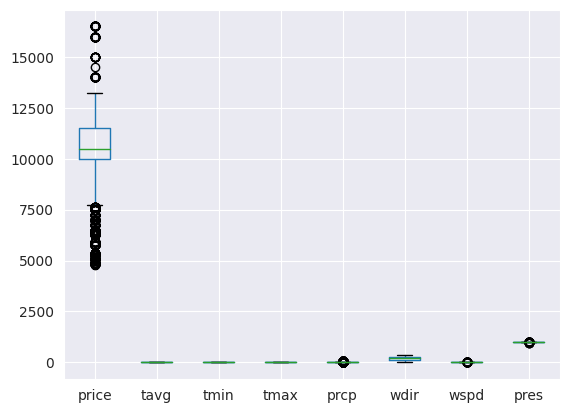

In [ ]:
df.boxplot()

In [ ]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 578


<Axes: >

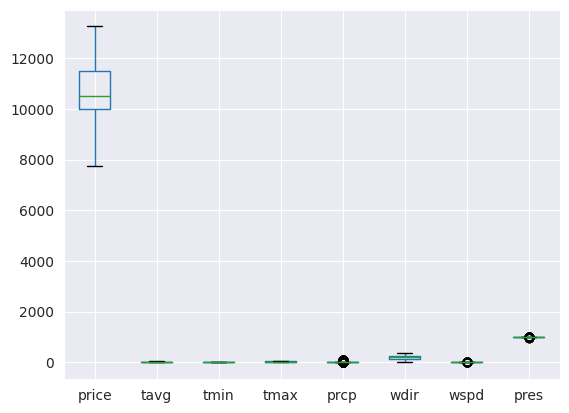

In [ ]:
df.boxplot()

In [ ]:
df = df.dropna()

In [ ]:
df_corr = df.copy()
df_corr.tavg = df_corr.tavg.shift(-30)
df_corr.pres = df_corr.pres.shift(60)



In [ ]:
# Find the pearson correlations matrix
corr = df_corr.corr(method = 'pearson')
corr

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
price,1.000000,0.434865,0.413297,0.397957,-0.231933,-0.003994,-0.204454,-0.313656
tavg,0.434865,1.000000,0.958312,0.955030,-0.331224,0.081624,-0.517171,-0.503182
tmin,0.413297,0.958312,1.000000,0.995815,-0.332704,0.116697,-0.515098,-0.467333
tmax,0.397957,0.955030,0.995815,1.000000,-0.323798,0.100518,-0.524617,-0.462655
prcp,-0.231933,-0.331224,-0.332704,-0.323798,1.000000,-0.104537,0.102153,0.170290
wdir,-0.003994,0.081624,0.116697,0.100518,-0.104537,1.000000,-0.003497,-0.013384
wspd,-0.204454,-0.517171,-0.515098,-0.524617,0.102153,-0.003497,1.000000,0.293084
pres,-0.313656,-0.503182,-0.467333,-0.462655,0.170290,-0.013384,0.293084,1.000000


In [ ]:
fillter_feature = ['price', 'tavg', 'pres',  'prcp']
df = df[fillter_feature]

In [ ]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,pres,prcp
price,1.000000,0.410797,-0.281839,-0.231933
tavg,0.410797,1.000000,-0.419981,-0.329943
pres,-0.281839,-0.419981,1.000000,0.167631
prcp,-0.231933,-0.329943,0.167631,1.000000


<Axes: xlabel='date'>

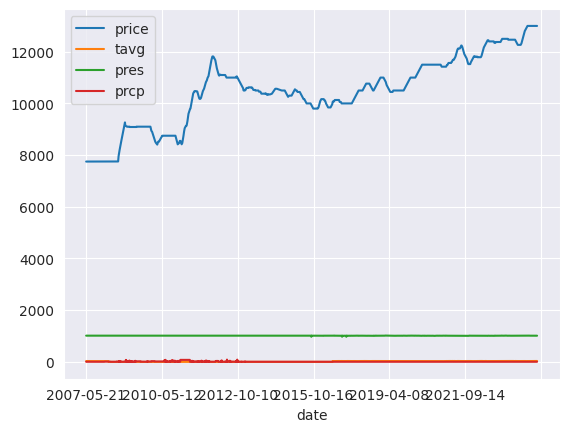

In [ ]:
df.price = df.price.rolling(45).mean()
df = df.dropna()
df.plot()

In [ ]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(2380, 4)
(595, 4)


## Kiểm tra stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8371
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.3622. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5486
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.5093. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [ ]:
df_differenced = df_train.diff().dropna()

In [ ]:
df_differenced

,price,tavg,pres,prcp
date,,,,
2007-05-22,0.000000,0.388889,0.0,0.319
2007-05-23,0.000000,1.333333,0.0,1.220
2007-05-24,0.000000,0.277778,0.0,0.000
2007-05-25,0.000000,-2.388889,0.0,0.000
2007-05-28,0.000000,-1.777778,0.0,-1.259
...,...,...,...,...
2021-03-05,11.111111,-0.111111,0.1,0.000
2021-03-08,11.111111,0.611111,0.2,0.000
2021-03-09,11.111111,-0.111111,-0.2,0.000


In [ ]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1822
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.9955
 No. Lags Chosen       = 2
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

<Axes: xlabel='date'>

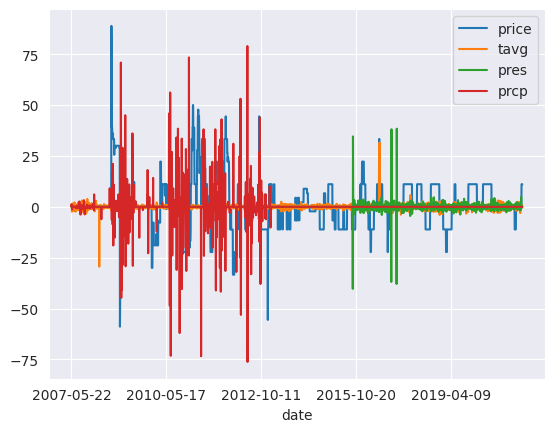

In [ ]:
df_differenced.plot()

## Train model

### Đánh giá mô hình VAR

In [ ]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [ ]:
columns_train = fillter_feature

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.0 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
arimax = auto_arima(df_differenced.price, exogenous = df_differenced[[ 'tavg', 'pres',  'prcp']],
           start_p=3,
           start_q=3,
           max_p=7,
           max_q=7,
            seasonal=False,
          trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=14062.175, Time=3.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18319.629, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14089.213, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16335.518, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=14060.692, Time=2.83 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14059.188, Time=0.86 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=14999.006, Time=1.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14057.789, Time=1.41 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=15427.894, Time=1.62 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14074.372, Time=0.90 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14059.242, Time=1.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14060.896, Time=1.81 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14058.247, Time=1.76 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 18.499 seconds


In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
# Forecast
n_periods = len(df_test)
fitted, confint = arimax.predict(n_periods=n_periods,
                                  exogenous=[ 'tavg', 'pres',  'prcp'],
                                  return_conf_int=True)


In [ ]:
np.square(fitted)

2379    1.056780e+02
2380    9.232456e+01
2381    8.213798e+01
2382    7.307534e+01
2383    6.501261e+01
            ...     
2969    1.147888e-28
2970    1.021237e-28
2971    9.085591e-29
2972    8.083138e-29
2973    7.191290e-29
Length: 595, dtype: float64

In [ ]:
df_test.index

Index(['2021-03-12', '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
       '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
       ...
       '2024-04-17', '2024-04-22', '2024-04-24', '2024-05-02', '2024-05-06',
       '2024-05-08', '2024-05-10', '2024-05-13', '2024-05-14', '2024-05-15'],
      dtype='object', name='date', length=595)

In [ ]:
fc_series = pd.DataFrame({'price': fitted.values}, index = df_test.index)

In [ ]:
fc_series

,price
date,
2021-03-12,1.027998e+01
2021-03-15,9.608567e+00
2021-03-16,9.063001e+00
2021-03-17,8.548411e+00
2021-03-18,8.063040e+00
...,...
2024-05-08,1.071395e-14
2024-05-10,1.010563e-14
2024-05-13,9.531837e-15


<Axes: xlabel='date'>

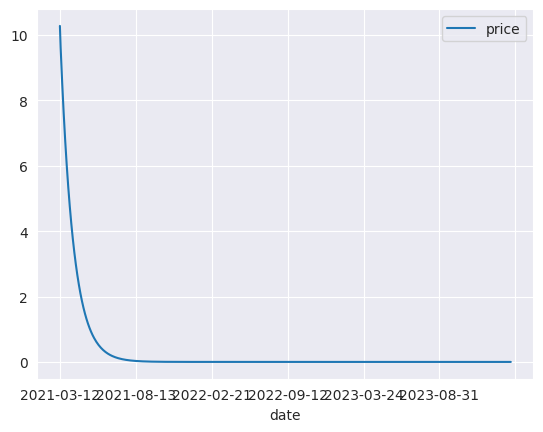

In [ ]:
fc_series.plot()

In [ ]:
fc_series.price = df_test.price.iloc[0] + fc_series.price.cumsum()

<Axes: xlabel='date'>

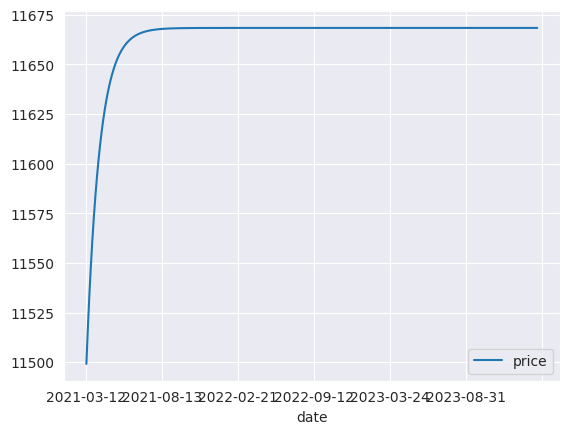

In [ ]:
fc_series.plot()

Đánh giá mô hình

In [ ]:
accuracy_prod = forecast_accuracy(fc_series['price'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  4.745
rmse :  719.0726


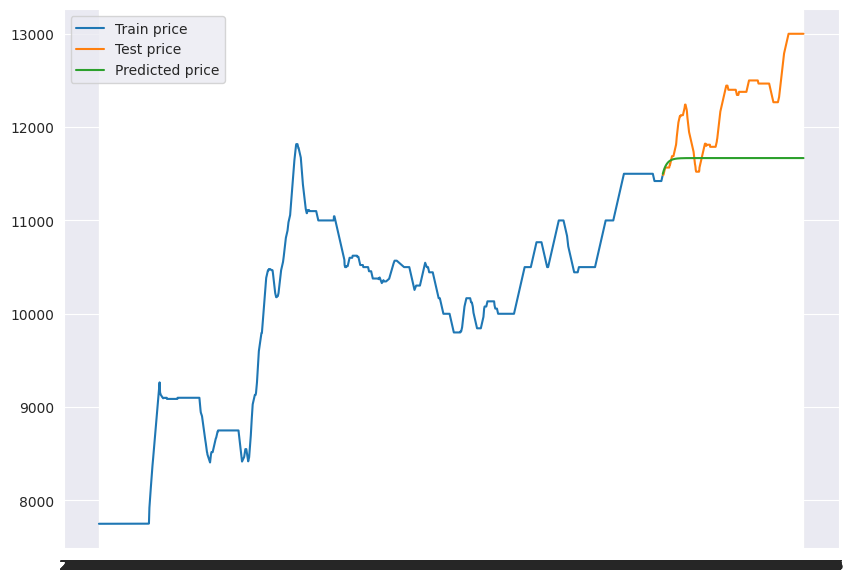

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(fc_series[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import joblib
# joblib.dump(arimax, varma_file_name)

# #

In [ ]:
import joblib
from google.colab import drive

file_name = "arimax_gia_lua_thoi_tiet.joblib"
drive.mount('/content/drive')

joblib.dump(arimax, '/content/gdrive/MyDrive/model/' + file_name)

['/content/gdrive/MyDrive/model/arimax_gia_lua_thoi_tiet.joblib']